# Projekt z przedmiotu "Statystyka i Teoria Obsługi Masowej"

## Modelowanie systemów kolejkowych

### Router jako system kolejkowy

Router to podstawowe urządzenie sieciowe odpowiedzialne za przesyłanie pakietów danych pomiędzy różnymi segmentami sieci. Gdy pakiet dociera do routera, jego główne zadania to:
1. analiza nagłówka pakietu i określenie najlepszego kierunku przesyłu (routing),
2. umieszczenie pakietu w kolejce wyjściowej, jeśli port docelowy jest aktualnie zajęty,
3. przesłanie pakietu dalej, gdy tylko pojawi się możliwość transmisji.

Routery nie przetwarzają pakietów natychmiast. Jeśli ruch jest intensywny (np. w godzinach szczytu), pakiety muszą poczekać w buforze. A gdy bufor się zapełni, nadchodzące pakiety są tracone.

#### Dlaczego router można modelować jako system kolejkowy?

Działanie routera dobrze odwzorowuje klasyczny system kolejkowy:
* **Pakiety przychodzą losowo**, zgodnie z procesem Poissona - jest to powszechnie stosowane założenie (w rzeczywistości ruch sieciowy bywa bardziej złożony np. burstowy lub skorelowany).
* **Czas przetwarzania pakietu** możemy opisać rozkładem wykładniczym, co odpowiada losowej długości obsługi.
* **Bufor routera działa jak kolejka** – jeśli port wyjściowy jest zajęty, pakiety oczekują.
* **Port wyjściowy routera pełni rolę serwera**, który obsługuje pakiety jeden po drugim.
* **Ograniczona pojemność bufora** pozwala modelować straty pakietów.

Choć przyjęte założenia są uproszczeniem, umożliwiają one analizę wpływu obciążenia i rozmiaru bufora na zachowanie routera, przy użyciu dobrze znanych modeli kolejkowych.

#### Modele M/M/1 i M/M/1/N jako uproszczone modele routera

W ramach projektu wykorzystujemy dwa klasyczne modele kolejkowe do opisania działania routera:
* **M/M/1:** Reprezentuje idealizowany router, w którym:
    * bufor ma nieskończoną pojemność,
    * pakiety nigdy nie są tracone, ale mogą bardzo długo czekać,
    * model ten pozwala zbadać zachowanie systemu bez efektu przeciążenia.
* **M/M/1/N:** Reprezentuje bardziej realistyczny przypadek:
    * bufor routera może pomieścić maksymalnie N pakietów (łącznie z przetwarzanym),
    * jeśli do systemu trafi więcej niż N pakietów, nadmiarowe pakiety są odrzucane,
    * model ten pozwala analizować prawdopodobieństwo utraty pakietu oraz wpływ rozmiaru bufora na wydajność.

#### Cel analizy

Celem analizy jest porównanie działania routera modelowanego za pomocą systemów kolejkowych M/M/1 oraz M/M/1/N w różnych warunkach obciążenia sieci. Chcemy odpowiedzieć na następujące pytania:
1. Jak bardzo ograniczona pojemność bufora wpływa na liczbę utraconych pakietów?
2. Jaka jest średnia liczba pakietów w systemie (E(L)) przy różnych poziomach obciążenia?
3. Czy większy bufor zawsze oznacza mniejsze straty?
4. Jakie są różnice między modelem teoretycznym bez strat a modelem z rzeczywistymi ograniczeniami?

### Teoretyczne podstawy modeli kolejkowych M/M/1 i M/M/1/N

Parametry kolejki:
* $\lambda$ - średnia liczba przychodzących pakietów na sekundę,
* $\mu$ - średnia liczba pakietów, które router może przetworzyć na sekundę,
* $\rho$ - obciążenie routera:
​
$$\rho = \frac{\lambda}{\mu}$$

System kolejkowy jest stabilny (ma stan stacjonarny) tylko wtedy, gdy:

$$\rho<1$$

#### Model M/M/1 

Model M/M/1 to najprostszy i najczęściej analizowany system kolejkowy, w którym:
* M: pakiety przychodzą losowo, zgodnie z procesem Poissona z natężeniem $\lambda$ - czasy między przyjściami mają rozkład wykładniczy.
* M: czasy obsługi są niezależne i mają również rozkład wykładniczy z parametrem $\mu$.
* 1: router posiada dokładnie jeden procesor/rdzeń obsługujący pakiety jeden po drugim.

Kolejka M/M/1 ma nieskończoną pojemność (brak odrzuceń), a pakiety są obsługiwane wg zasady FIFO (First In, First Out).

**Średnia liczba pakietów w systemie:**
$$E(L)=\frac{\rho}{1-\rho}$$

**Średni czas obsługi pakietu (z prawa Little'a):**
$$E(S)=\frac{E(L)}{\lambda}=\frac{\rho}{\lambda (1-\rho)}=\frac{\frac{1}{\mu}}{1-\rho}$$

#### Model M/M/1/N

Model M/M/1/N to rozszerzenie modelu M/M/1, w którym system może pomieścić maksymalnie N pakietów jednocześnie (obsługiwanych + w kolejce). Jeśli przychodzi pakiet, a system jest pełny (jest już N pakietów), pakiet zostaje odrzucony.

System M/M/1/N to tzw. model z stratami.

**Prawdopodobieństwo, że w systemie jest dokładnie k klientów:**
$$P_k=P_0 \cdot \rho^k\quad dla\ k=0,1,...,N$$

gdzie:

$$P_0=\frac{1-\rho}{1-\rho^{N+1}}\quad (dla\ \rho \neq 1)$$

**Prawdopodobiństwo straty pakietu:**
$$P_{loss}=P_N=\frac{(1-\rho)\rho^N}{1-\rho^{N+1}}$$

**Średnia liczba pakietów w systemie:**
$$E(L)=\sum_{k=1}^{N} k \cdot P_k$$

### Symulacja działania routera w modelach kolejkowych

#### Implementacja modeli kolejkowych M/M/1 i M/M/1/N

##### Definicja klasy zdarzenia Event

In [195]:
import numpy as np
import heapq
import matplotlib.pyplot as plt

class Event:
    """
    Klasa reprezentująca pojedyncze zdarzenie w symulacji (przyjście lub odejście klienta).
    
    Attributes:
        time (float): Czas wystąpienia zdarzenia.
        type (str): Typ zdarzenia ('arrival' lub 'departure').
    """
    def __init__(self, time, event_type):
        self.time = time
        self.type = event_type  # 'arrival' lub 'departure'
    def __lt__(self, other):
        # Potrzebne do prawidłowego sortowania w kolejce priorytetowej (heapq)
        return self.time < other.time

Ta klasa reprezentuje pojedyncze zdarzenie w symulacji:
* `time` – czas wystąpienia zdarzenia,

* `type` – typ zdarzenia: `'arrival'` (przyjście pakietu) lub `'departure'` (obsługa zakończona).

Zdarzenia są dodawane do kolejki priorytetowej (`heapq`), dzięki czemu zawsze przetwarzane są w kolejności rosnącego czasu. Porównywanie (`__lt__`) jest nadpisane, aby sortowanie działało poprawnie.

##### Model M/M/1 - `MM1QueueSimulator`

In [198]:
class MM1QueueSimulator:
    """
    Symulator systemu kolejkowego typu M/M/1 (nieskończony bufor).
    
    Parametry:
        arrival_rate (float): Intensywność przyjść λ (średnia liczba pakietów na jednostkę czasu).
        service_rate (float): Intensywność obsługi μ (średnia liczba obsługiwanych pakietów na jednostkę czasu).
        max_time (float): Maksymalny czas trwania symulacji.
    """
    def __init__(self, arrival_rate, service_rate, max_time):
        self.lambda_ = arrival_rate
        self.mu = service_rate
        self.max_time = max_time
        
        # Kolejka zdarzeń
        self.event_queue = []
        # Kolejka pakietów oczekujących na obsługę
        self.queue = []
        self.server_busy = False  # Czy serwer jest zajęty
        self.current_time = 0
        self.served_packages = 0  # Liczba obsłużonych pakietów
        self.total_packages = 0   # Całkowita liczba przychodzących pakietów
        self.queue_lengths = []    # Historia długości kolejki (do obliczenia E(L))

    def schedule_event(self, event):
        """Dodaje zdarzenie do kolejki priorytetowej."""
        heapq.heappush(self.event_queue, event)

    def run(self):
        """
        Uruchamia symulację systemu M/M/1.
        
        Zwraca:
            dict: Słownik z liczbą obsłużonych klientów, całkowitą liczbą klientów i średnią liczbą w systemie (E(L)).
        """
        # Pierwsze przyjście
        self.schedule_event(Event(np.random.exponential(1/self.lambda_), 'arrival'))

        while self.event_queue:
            event = heapq.heappop(self.event_queue)
            self.current_time = event.time
            if self.current_time > self.max_time:
                break

            if event.type == 'arrival':
                self.total_packages += 1
                in_system = len(self.queue) + int(self.server_busy)
                self.queue_lengths.append(in_system)

                if not self.server_busy:
                    self.server_busy = True
                    service_time = np.random.exponential(1/self.mu)
                    self.schedule_event(Event(self.current_time + service_time, 'departure'))
                else:
                    self.queue.append(self.current_time)

                next_arrival = np.random.exponential(1/self.lambda_)
                self.schedule_event(Event(self.current_time + next_arrival, 'arrival'))

            elif event.type == 'departure':
                self.served_packages += 1
                if self.queue:
                    self.queue.pop(0)
                    service_time = np.random.exponential(1/self.mu)
                    self.schedule_event(Event(self.current_time + service_time, 'departure'))
                else:
                    self.server_busy = False

        return {
            'served': self.served_packages,
            'total': self.total_packages,
            'E(L)': np.mean(self.queue_lengths)
        }

##### Model M/M/1/N - `MM1NQueueSimulator`

In [200]:
class MM1NQueueSimulator(MM1QueueSimulator):
    """
    Symulator systemu kolejkowego typu M/M/1/N (ograniczony bufor).
    
    Dodatkowy parametr:
        buffer_size (int): Maksymalna liczba klientów w systemie (łącznie z tym obsługiwanym).
    """
    def __init__(self, arrival_rate, service_rate, max_time, buffer_size):
        super().__init__(arrival_rate, service_rate, max_time)
        self.buffer_size = buffer_size
        self.blocked_packages = 0  # Liczba odrzuconych pakietów (gdy system pełny)

    def run(self):
        """
        Uruchamia symulację systemu M/M/1/N.
        
        Zwraca:
            dict: Statystyki – liczba obsłużonych klientów, całkowita liczba klientów,
                  średnia liczba w systemie (E(L)), prawdopodobieństwo straty (P(loss)).
        """
        self.schedule_event(Event(np.random.exponential(1/self.lambda_), 'arrival'))

        while self.event_queue:
            event = heapq.heappop(self.event_queue)
            self.current_time = event.time
            if self.current_time > self.max_time:
                break

            if event.type == 'arrival':
                in_system = len(self.queue) + int(self.server_busy)
                if in_system < self.buffer_size:
                    self.total_packages += 1
                    self.queue_lengths.append(in_system)
                    if not self.server_busy:
                        self.server_busy = True
                        service_time = np.random.exponential(1/self.mu)
                        self.schedule_event(Event(self.current_time + service_time, 'departure'))
                    else:
                        self.queue.append(self.current_time)
                else:
                    self.blocked_packages += 1

                next_arrival = np.random.exponential(1/self.lambda_)
                self.schedule_event(Event(self.current_time + next_arrival, 'arrival'))

            elif event.type == 'departure':
                self.served_packages += 1
                if self.queue:
                    self.queue.pop(0)
                    service_time = np.random.exponential(1/self.mu)
                    self.schedule_event(Event(self.current_time + service_time, 'departure'))
                else:
                    self.server_busy = False

        return {
            'served': self.served_packages,
            'total': self.total_packages + self.blocked_packages,
            'E(L)': np.mean(self.queue_lengths),
            'P(loss)': self.blocked_packages / (self.total_packages + self.blocked_packages),
            'blocked': self.blocked_packages
        }

#### Dobór liczby powtórzeń symulacji (analiza błędu SE)

Przed rozpoczęciem zasadniczych eksperymentów konieczne było oszacowanie minimalnej liczby powtórzeń symulacji, które zapewniają statystycznie wiarygodne wyniki. W tym celu sprawdzono, jak zmienia się błąd standardowy (SE) średniej wartości metryki E(L) (średniej liczby pakietów w systemiew zależności od liczby uruchomień modelu. Analizowano, od którego momentu SE pozostaje stabilnie poniżej ustalonego progu:
$$SE=\frac{s}{\sqrt{n}}\leq 0.1$$

gdzie:
* $s$ - odchylenie standardowe wyników,
* $n$ - liczba przeprowadzonych symulacji.

##### Parametry eksperymentu

* Model: M/M/1 - wybrany ze względu na brak ograniczeń bufora, co może skutkować większą niestabilnością wyników.
* Czas symulacji: 3600 sekund (1 godzina pracy routera),
* Intensywność obsługi: μ = 100 (maksymalnie 100 pakietów na sekundę),
* Obciążenie systemu: ρ = 0.8 (czyli λ = 80) – założono, że router w warunkach normalnej pracy działa z obciążeniem sięgającym 80%.

In [ ]:
def estimate_se_for_model(model_class, model_args, metric_key='E(L)', max_runs=30):
    """
    Uruchamia model kolejowy wielokrotnie i mierzy średnią oraz błąd standardowy (SE) po każdej iteracji.

    Args:
        model_class: Klasa modelu symulacyjnego (np. MM1QueueSimulator)
        model_args: Lista argumentów przekazywanych do modelu
        metric_key: Nazwa metryki do śledzenia (np. 'E(L)', 'P(loss)')
        max_runs: Maksymalna liczba uruchomień

    Returns:
        Tuple (list of means, list of SEs)
    """
    results = []
    means = []
    ses = []

    for i in range(1, max_runs + 1):
        model = model_class(*model_args)
        res = model.run()
        results.append(res[metric_key])

        mean = np.mean(results)
        se = np.std(results, ddof=1) / np.sqrt(i) if i > 1 else 0.0

        means.append(mean)
        ses.append(se)

    return means, ses

# Przykład testowy: M/M/1, rho=0.8
rho = 0.8
mu = 100.0
lam = rho * mu
sim_time = 3600

# Wywołanie dla metryki 'E(L)' w systemie M/M/1
means, ses = estimate_se_for_model(MM1QueueSimulator, [lam, mu, sim_time], metric_key='E(L)', max_runs=100)

##### Wykres: Zmiana błędu SE metryki E(L) w zależności od liczby powtórzeń

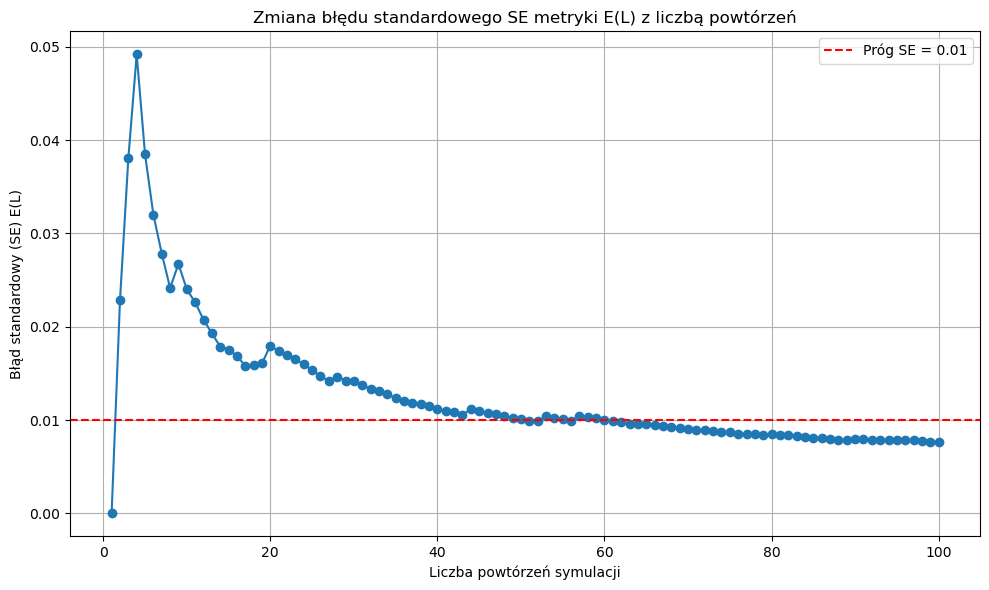

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), ses, marker='o')
plt.axhline(0.01, color='red', linestyle='--', label='Próg SE = 0.01')
plt.xlabel("Liczba powtórzeń symulacji")
plt.ylabel("Błąd standardowy (SE) E(L)")
plt.title("Zmiana błędu standardowego SE metryki E(L) z liczbą powtórzeń")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Wynik: Minimalna liczba powtórzeń spełniająca kryterium

In [130]:
se_threshold = 0.01
min_index = None

for i in range(len(ses)):
    if all(se <= se_threshold for se in ses[i:]):
        min_index = i + 1
        break

if min_index:
    print(f"Minimalna liczba powtórzeń, od której SE zawsze ≤ {se_threshold}: {min_index}")
else:
    print("Nie znaleziono liczby powtórzeń spełniającej warunek SE ≤ próg.")

Minimalna liczba powtórzeń, od której SE zawsze ≤ 0.01: 60


##### Wniosek

Na podstawie analizy ustalono, że dla wybranych parametrów modelu M/M/1 i metryki E(L), stabilne i wiarygodne statystyki uzyskuje się przy co najmniej 60 powtórzeniach symulacji. Liczbę tę przyjęto jako standard w dalszych analizach (zarówno dla M/M/1, jak i M/M/1/N).

Dalsze zwiększanie liczby powtórzeń przynosi znikome korzyści przy znacznym wzroście czasu obliczeń.

#### Symulacja modeli M/M/1 i M/M/1/N dla różnych obciążeń i rozmiarów bufora

W tej części przeprowadzono zasadniczą symulację porównawczą modeli kolejkowych: klasycznego M/M/1 oraz jego rozszerzenia M/M/1/N z ograniczonym buforem. Symulacja została wykonana dla różnych poziomów obciążenia systemu (ρ) oraz różnych rozmiarów bufora (N) w celu zbadania wpływu tych parametrów na wydajność systemu - mierzoną m.in. średnią liczbą pakietów w systemie E(L), liczbą obsłużonych pakietów oraz prawdopodobieństwem odrzucenia pakietu P(loss).

In [160]:
def compare_models_with_repeats(rho_values, buffer_sizes, sim_time=3600, n_runs=60):
    mu = 100.0
    results = []
    raw_mm1 = []
    raw_mm1n = []

    for rho in rho_values:
        lam = rho * mu
        mm1_results = []

        for _ in range(n_runs):
            mm1 = MM1QueueSimulator(lam, mu, sim_time)
            res = mm1.run()
            mm1_results.append(res)
            raw_mm1.append({
                'model': 'M/M/1',
                'rho': rho,
                'N': None,
                'E(L)': res['E(L)'],
                'served': res['served'],
                'P(loss)': None,
                'blocked': None
            })

        mm1_avg = {
            'E(L)': np.mean([r['E(L)'] for r in mm1_results]),
            'served': np.mean([r['served'] for r in mm1_results])
        }

        for N in buffer_sizes:
            mm1n_results = []
            for _ in range(n_runs):
                mm1n = MM1NQueueSimulator(lam, mu, sim_time, N)
                res = mm1n.run()
                mm1n_results.append(res)
                raw_mm1n.append({
                    'model': f'M/M/1/{N}',
                    'rho': rho,
                    'N': N,
                    'E(L)': res['E(L)'],
                    'served': res['served'],
                    'P(loss)': res['P(loss)'],
                    'blocked': res['blocked']
                })

            mm1n_avg = {
                'E(L)': np.mean([r['E(L)'] for r in mm1n_results]),
                'P(loss)': np.mean([r['P(loss)'] for r in mm1n_results]),
                'served': np.mean([r['served'] for r in mm1n_results]),
                'blocked': np.mean([r['blocked'] for r in mm1n_results])
            }

            results.append({
                'rho': rho,
                'N': N,
                'E(L)_M/M/1': mm1_avg['E(L)'],
                'E(L)_M/M/1/N': mm1n_avg['E(L)'],
                'P(loss)_M/M/1/N': mm1n_avg['P(loss)'],
                'served_M/M/1': mm1_avg['served'],
                'served_M/M/1/N': mm1n_avg['served'],
                'served_diff': mm1_avg['served'] - mm1n_avg['served'],
                'blocked': mm1n_avg['blocked']
            })

    df = pd.DataFrame(results)
    raw_mm1_df = pd.DataFrame(raw_mm1)
    raw_mm1n_df = pd.DataFrame(raw_mm1n)

    return df, raw_mm1_df, raw_mm1n_df


rho_values = np.linspace(0.1, 0.8, 8)
buffer_sizes = [5, 10, 20]
sim_time = 3600
n_runs = 60

df, raw_mm1_df, raw_mm1n_df = compare_models_with_repeats(rho_values, buffer_sizes, sim_time, n_runs)

Poniższy wykres przedstawia rozkład średniej liczby pakietów w systemie E(L) dla modelu M/M/1 w zależności od obciążenia ρ. Wraz ze wzrostem ρ rośnie zarówno wartość oczekiwana E(L), jak i rozrzut wyników, co wskazuje na pogarszającą się stabilność systemu przy dużym obciążeniu.

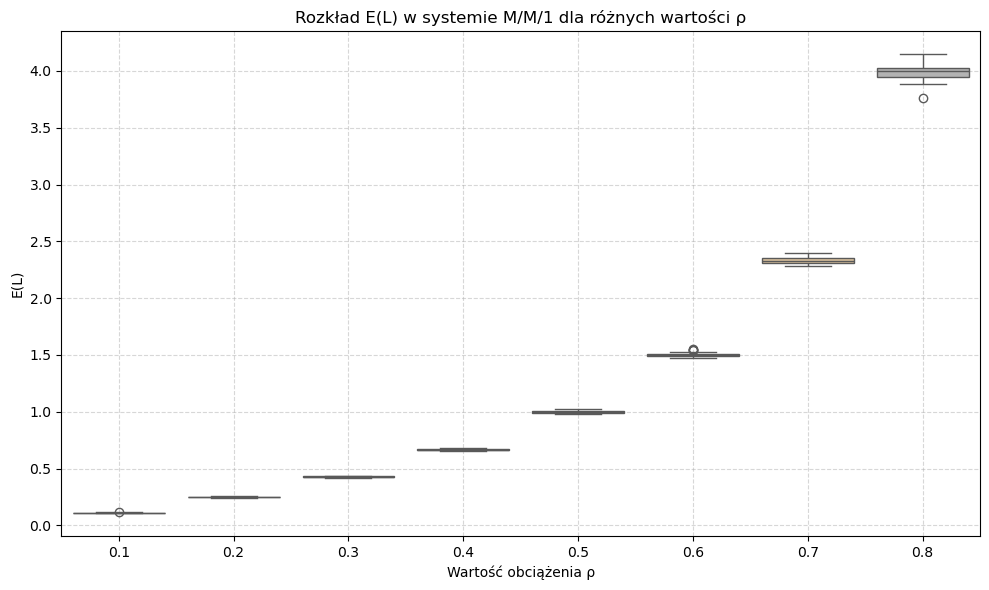

In [226]:
raw_mm1_df['rho'] = raw_mm1_df['rho'].round(1)
raw_mm1n_df['rho'] = raw_mm1_df['rho'].round(1)
df['rho2'] = df['rho'].round(1)

plt.figure(figsize=(10, 6))
sns.boxplot(data=raw_mm1_df, x='rho', y='E(L)', palette='Set2', hue='rho', legend=False)
plt.title("Rozkład E(L) w systemie M/M/1 dla różnych wartości ρ")
plt.xlabel("Wartość obciążenia ρ")
plt.ylabel("E(L)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Wykres ilustruje, jak zmienia się E(L) w modelu M/M/1/N dla różnych wartości ρ i wielkości bufora N. Większy bufor pozwala na obsłużenie większej liczby pakietów bez odrzutów, ale jednocześnie prowadzi do wzrostu liczby pakietów oczekujących w systemie.

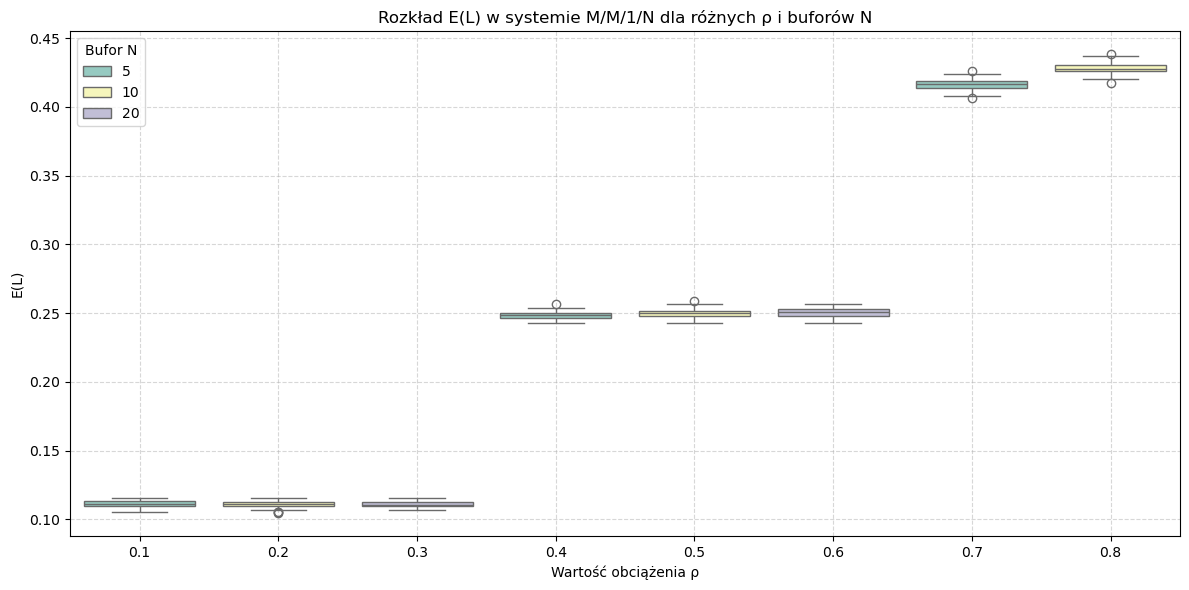

In [162]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=raw_mm1n_df, x='rho', y='E(L)', hue='N', palette='Set3')
plt.title("Rozkład E(L) w systemie M/M/1/N dla różnych ρ i buforów N")
plt.xlabel("Wartość obciążenia ρ")
plt.ylabel("E(L)")
plt.legend(title='Bufor N')
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

#### Analiza wyników

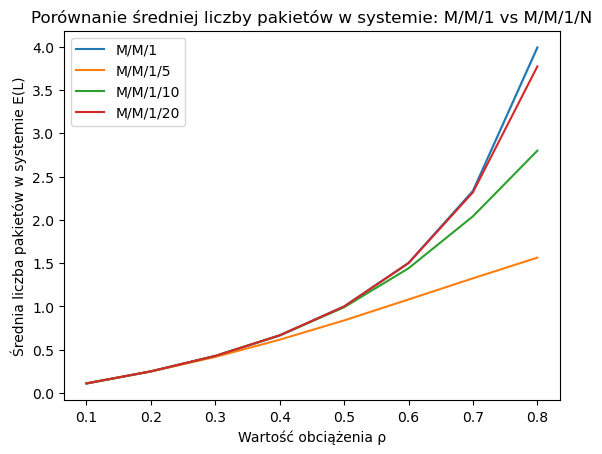

In [163]:
plt.figure()
sns.lineplot(data=df, x='rho', y='E(L)_M/M/1', label='M/M/1')
for N in buffer_sizes:
    sns.lineplot(data=df[df.N == N], x='rho', y='E(L)_M/M/1/N', label=f'M/M/1/{N}')
plt.title('Porównanie średniej liczby pakietów w systemie: M/M/1 vs M/M/1/N')
plt.ylabel('Średnia liczba pakietów w systemie E(L)')
plt.xlabel('Wartość obciążenia ρ')
plt.legend()
plt.show()

Średnia liczba pakietów w systemie E(L) rośnie wraz z obciążeniem ρ, ale tempo wzrostu zależy od rozmiaru bufora. W modelu M/M/1 (brak ograniczeń) wzrost jest najszybszy, co może prowadzić do przeciążenia systemu. W modelach M/M/1/N bufor ogranicza długość kolejki, przez co E(L) rośnie wolniej, szczególnie dla mniejszych wartości N. Różnice między krzywymi pokazują, że im większy bufor, tym bardziej system zachowuje się jak model M/M/1.

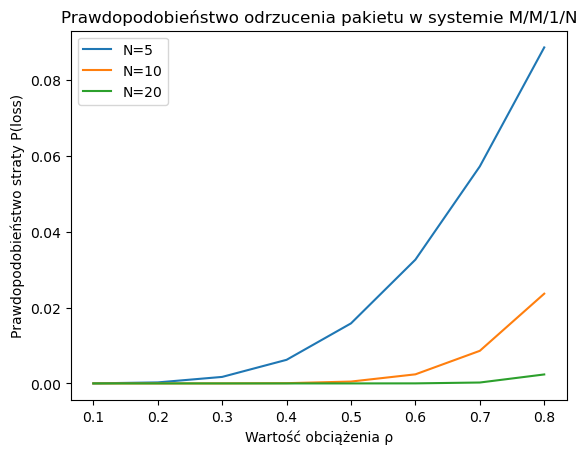

In [164]:
plt.figure()
for N in buffer_sizes:
    sns.lineplot(data=df[df.N == N], x='rho', y='P(loss)_M/M/1/N', label=f'N={N}')
plt.title('Prawdopodobieństwo odrzucenia pakietu w systemie M/M/1/N')
plt.ylabel('Prawdopodobieństwo straty P(loss)')
plt.xlabel('Wartość obciążenia ρ')
plt.legend()
plt.show()

Prawdopodobieństwo straty pakietu rośnie gwałtownie wraz ze wzrostem obciążenia, zwłaszcza przy małym buforze (N=5). Bufory o większej pojemności (N=10 i N=20) skutecznie redukują straty aż do poziomów ρ bliskich 0.8, co pokazuje ich ochronną funkcję. Mimo to przy bardzo dużym obciążeniu również większe bufory nie są w stanie całkowicie wyeliminować strat.

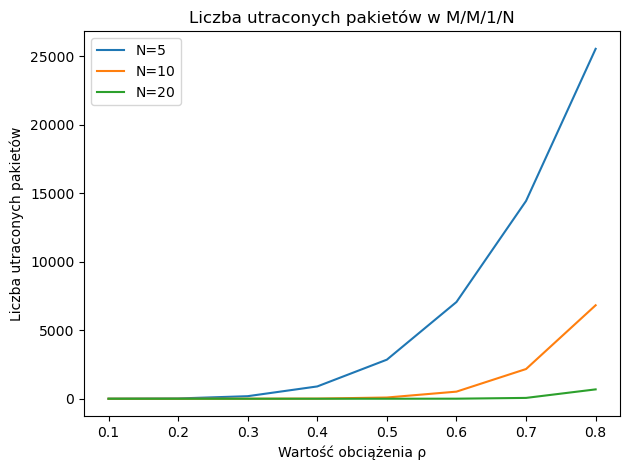

In [165]:
plt.figure()
for N in sorted(df["N"].unique()):
    subset = df[df["N"] == N]
    plt.plot(subset["rho"], subset["blocked"], label=f"N={N}")
plt.xlabel("Wartość obciążenia ρ")
plt.ylabel("Liczba utraconych pakietów")
plt.title("Liczba utraconych pakietów w M/M/1/N")
plt.legend()
plt.tight_layout()
plt.show()

Bezwzględna liczba utraconych pakietów znacząco wzrasta dla buforów o małej pojemności i dużym obciążeniu. Bufor N=5 skutkuje utratą ponad 25 000 pakietów przy ρ = 0.8, podczas gdy przy N=20 liczba ta nie przekracza 1000. Pokazuje to, że dobór bufora ma bezpośredni wpływ na jakość usług w systemie kolejkowym - zbyt mały bufor prowadzi do masowego odrzucania pakietów.

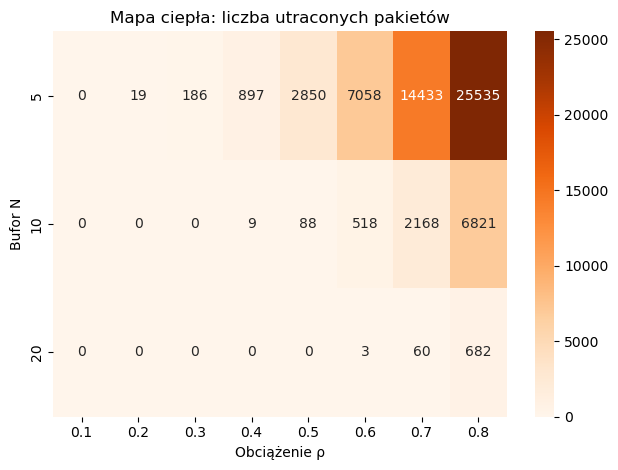

In [228]:
pivot = df.pivot(index="N", columns="rho2", values="blocked")
plt.figure()
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Oranges")
plt.title("Mapa ciepła: liczba utraconych pakietów")
plt.xlabel("Obciążenie ρ")
plt.ylabel("Bufor N")
plt.tight_layout()
plt.show()

Mapa ciepła potwierdza obserwacje z wykresu liniowego, uwypuklając wpływ kombinacji parametrów ρ i N. Im większe obciążenie i mniejszy bufor, tym intensywniejsza „strefa strat”. Wizualizacja pozwala szybko zidentyfikować niebezpieczne zakresy pracy routera – np. bufor N=5 przestaje być skuteczny już od ρ ≈ 0.5.

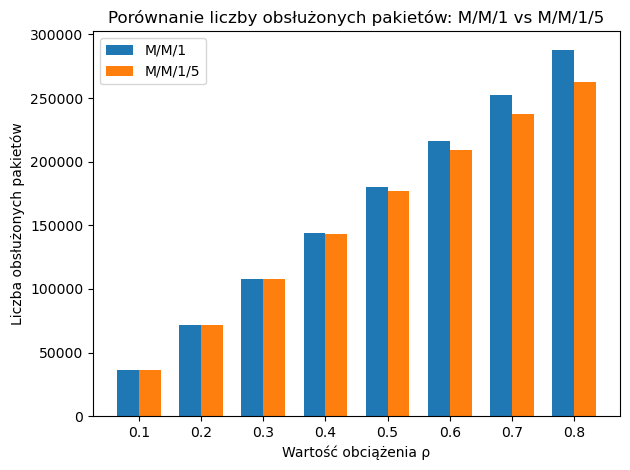

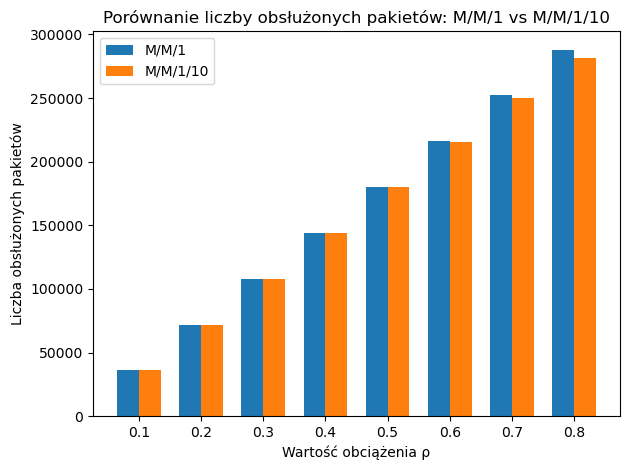

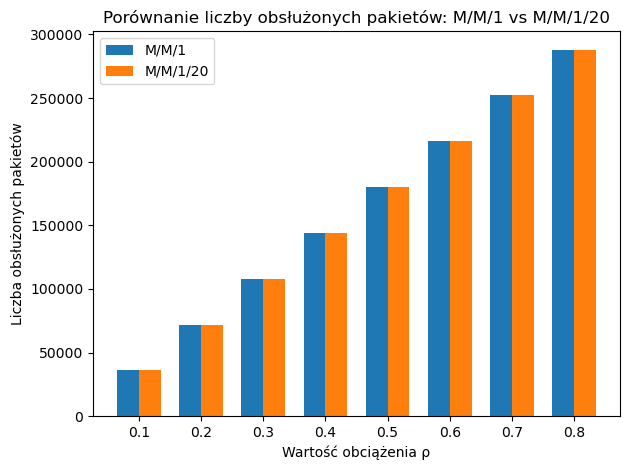

In [167]:
unique_rhos = sorted(df["rho"].unique())
N_values = sorted(df["N"].unique())
width = 0.35

for N in N_values:
    subset = df[df["N"] == N]
    ind = np.arange(len(unique_rhos))

    plt.figure()
    plt.bar(ind - width/2, subset["served_M/M/1"], width, label="M/M/1")
    plt.bar(ind + width/2, subset["served_M/M/1/N"], width, label=f"M/M/1/{N}")

    plt.xticks(ind, [f"{rho:.1f}" for rho in unique_rhos])
    plt.xlabel("Wartość obciążenia ρ")
    plt.ylabel("Liczba obsłużonych pakietów")
    plt.title(f"Porównanie liczby obsłużonych pakietów: M/M/1 vs M/M/1/{N}")
    plt.legend()
    plt.tight_layout()
    plt.show()

W modelu M/M/1 liczba obsłużonych pakietów zawsze jest wyższa niż w odpowiadających mu modelach M/M/1/N, szczególnie przy dużych wartościach ρ. Ograniczony bufor powoduje odrzucenie pakietów, co obniża efektywną przepustowość systemu. Różnica ta jest największa dla N=5, a dla N=20 niemal zanika - potwierdzając, że większy bufor pozwala routerowi utrzymać zbliżoną wydajność do modelu idealnego (bezstratnego).

### Podsumowanie

Przeprowadzona analiza pozwoliła porównać zachowanie idealnego modelu kolejkowego (M/M/1) z bardziej realistycznym modelem uwzględniającym ograniczoną pojemność bufora (M/M/1/N). Symulacje pokazały, że choć brak ograniczeń eliminuje straty pakietów, to prowadzi do niekontrolowanego wzrostu kolejki przy dużym obciążeniu. W rzeczywistości routery zawsze mają ograniczoną pamięć, dlatego nieuniknione są decyzje projektowe dotyczące wielkości bufora i akceptowalnego poziomu strat. Wyniki podkreślają znaczenie świadomego kompromisu między opóźnieniami a niezawodnością transmisji.